# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from skopt import BayesSearchCV

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          DeprecationWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4460 features


## Hyperparameter Tuning

Bayesian search on `LogisticRegression` with `BayesSearchCV`

In [5]:
# Set up classifier pipeline
estimator = LogisticRegression(solver='lbfgs', penalty='l2',
                               max_iter=3000, random_state=SEED)

pipe = Pipeline([('scaler', MaxAbsScaler()), ('clf', estimator)])

In [6]:
# Callback function
def status_print(optim_result):
    """Status callback durring Bayesian hyperparameter search"""
    
    # Get current parameters and the best parameters 
    n = len(pd.DataFrame(opt.cv_results_))
    print('Iteration %i, best %s score: %.6f'\
          % (n, scoring, opt.best_score_))

In [7]:
# Perform hyperparameter optimization
param_space = {'clf__C': (1e-3, 1e2, 'log-uniform')}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

opt = BayesSearchCV(pipe, param_space,cv=cv, scoring=scoring, n_iter=50,
                    n_jobs=5, verbose=0, random_state=SEED)

cv_results = opt.fit(X_train, y_train, callback=status_print)

Iteration 1, best neg_log_loss score: -0.250639
Iteration 2, best neg_log_loss score: -0.177356
Iteration 3, best neg_log_loss score: -0.174550
Iteration 4, best neg_log_loss score: -0.132266
Iteration 5, best neg_log_loss score: -0.128881
Iteration 6, best neg_log_loss score: -0.128881
Iteration 7, best neg_log_loss score: -0.121837
Iteration 8, best neg_log_loss score: -0.121837
Iteration 9, best neg_log_loss score: -0.121837
Iteration 10, best neg_log_loss score: -0.112393
Iteration 11, best neg_log_loss score: -0.112337
Iteration 12, best neg_log_loss score: -0.112115
Iteration 13, best neg_log_loss score: -0.112115
Iteration 14, best neg_log_loss score: -0.112115
Iteration 15, best neg_log_loss score: -0.112115
Iteration 16, best neg_log_loss score: -0.112115
Iteration 17, best neg_log_loss score: -0.112115
Iteration 18, best neg_log_loss score: -0.112115
Iteration 19, best neg_log_loss score: -0.112115
Iteration 20, best neg_log_loss score: -0.112115
Iteration 21, best neg_log_lo

In [8]:
# Set best estimator as classifier
opt.best_params_

print('Test %s score: %.4f' % (scoring, opt.score(X_test, y_test)))
pipe = opt.best_estimator_

{'clf__C': 9.492080336286511}

Test neg_log_loss score: -0.1021


              precision    recall  f1-score   support

           0     0.9734    0.9985    0.9858     19657
           1     0.9701    0.6446    0.7745      1508

    accuracy                         0.9733     21165
   macro avg     0.9717    0.8215    0.8801     21165
weighted avg     0.9732    0.9733    0.9707     21165



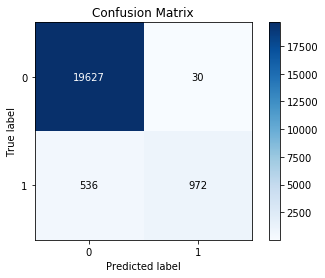

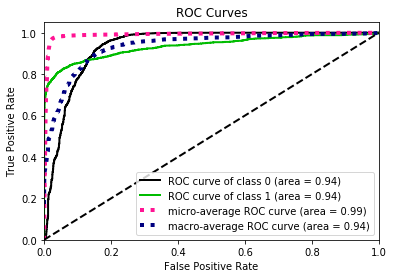

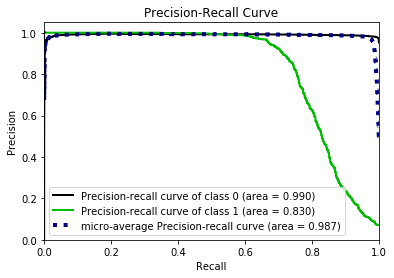

In [9]:
# Evaluate model

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9672    0.9663    0.9668     36476
           1     0.5611    0.5680    0.5645      2764

    accuracy                         0.9383     39240
   macro avg     0.7642    0.7672    0.7657     39240
weighted avg     0.9386    0.9383    0.9385     39240



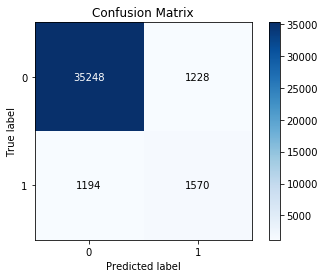

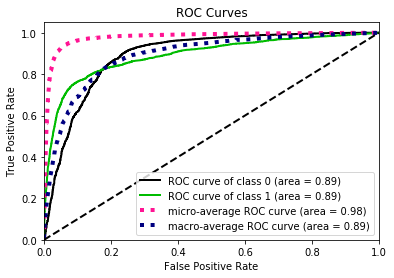

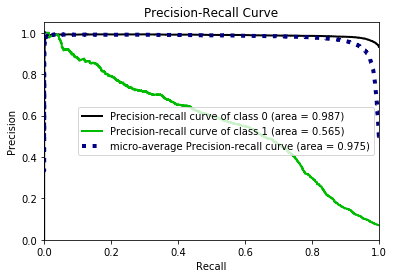

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9663    0.9757    0.9710     49151
           1     0.6166    0.5348    0.5728      3590

    accuracy                         0.9457     52741
   macro avg     0.7915    0.7553    0.7719     52741
weighted avg     0.9425    0.9457    0.9439     52741



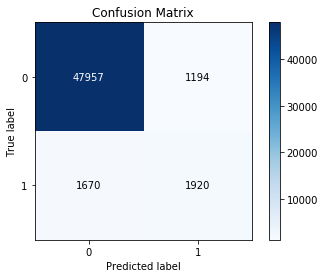

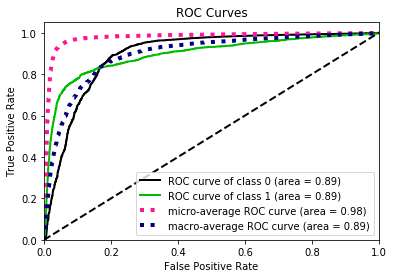

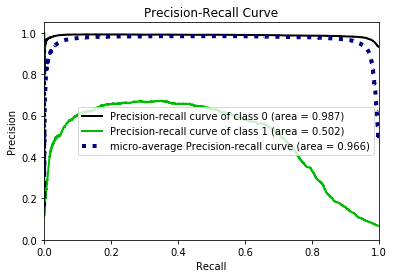

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9697    0.9825    0.9760     12654
           1     0.7824    0.6723    0.7232      1187

    accuracy                         0.9559     13841
   macro avg     0.8760    0.8274    0.8496     13841
weighted avg     0.9536    0.9559    0.9543     13841



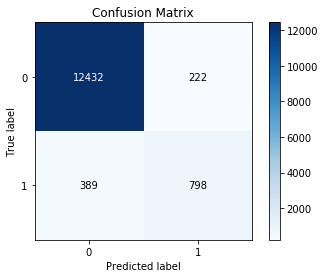

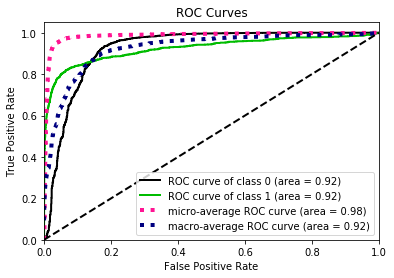

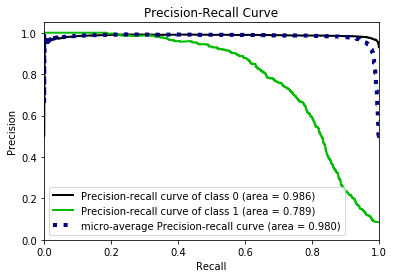

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train pipeline
    _ = pipe.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [11]:
# Refit model with the whole dataset
_ = pipe.fit(X, y)

# Dump model as pickle
_ = joblib.dump(pipe, 'best_model.pkl')

## Examine feature importances from coefficients

In [19]:
# Get feature names: Pfam set and graph properties
f_out = os.path.join(parent_dir, 'data', 'human_ppi_topology.tsv')

pfam_feats = joblib.load('pfam.pkl')[1]
graph_feats = pd.read_csv(f_out, sep='\t', index_col=0).columns.tolist()

feat_names = np.array(pfam_feats + graph_feats)
feat_names

array(['PF00001', 'PF00002', 'PF00004', ..., 'Degree_centrality',
       'Clustering_coefficient', 'Betweenness_centrality'], dtype='<U22')

In [64]:
# Get model coefficients
pipe = joblib.load('best_model.pkl')
coefs = pipe['clf'].coef_[0]

(4460,)

In [102]:
sort_index = coefs.argsort()[::-1] # descending
sorted_coefs = coefs[sort_index]
sorted_feats = feat_names[sort_index]

df = pd.DataFrame([sorted_feats, sorted_coefs], index=['Feature_name', 'Coefficient']).T

In [104]:
# Calculate odds
df['Odds'] = np.exp(df['Coefficient'].astype(float))
df.head(10)
df.tail(10)

,Feature_name,Coefficient,Odds
0,PF13912,14.0104,1.215198e+06
1,PF07705,13.1396,5.087093e+05
2,PF16620,12.9987,4.418215e+05
3,PF00041,11.3294,8.323263e+04
4,PF13465,11.2994,8.077671e+04
5,PF00435,10.8321,5.062100e+04
6,PF10633,10.6391,4.173661e+04
7,PF13921,10.2303,2.772994e+04
8,PF07679,10.113,2.466236e+04
9,PF18345,9.48626,1.317746e+04


,Feature_name,Coefficient,Odds
4450,PF00704,-9.0321,1.195111e-04
4451,PF04389,-9.18946,1.021102e-04
4452,PF02535,-9.37419,8.488698e-05
4453,PF00249,-9.48108,7.628173e-05
4454,PF13894,-9.56259,7.031069e-05
4455,PF00102,-9.58178,6.897406e-05
4456,PF07686,-11.1481,1.440195e-05
4457,PF08205,-11.8264,7.308816e-06
4458,PF00059,-12.3862,4.175839e-06
4459,PF04851,-14.2086,6.749617e-07


In [106]:
# Get unimportant features
unimportant_features = feat_names[coefs==0]

<hr></hr>